In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
project_path = "/content/drive/MyDrive/Noise_Heatmap_Project"
data_path_month = project_path + "/data/station_month.csv"
data_path_stations = project_path + "/data/stations.csv"


In [ ]:
!pip install geopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [ ]:
month = pd.read_csv(data_path_month)
stations = pd.read_csv(data_path_stations)

month.head(), stations.head()


(  Station  Year  Month   Day  Night  DayLimit  NightLimit
 0   BEN01  2011      2  66.0   56.0        55          45
 1   BEN01  2011      3  66.0   58.0        55          45
 2   BEN01  2011      4  66.0   57.0        55          45
 3   BEN01  2011      5  66.0   56.0        55          45
 4   BEN01  2011      6  67.0   57.0        55          45,
   Station            Name   City  State        Type
 0   DEL01  Dilshad Garden  Delhi  Delhi     Silence
 1   DEL02        CPCB, HQ  Delhi  Delhi  Commercial
 2   DEL03     DCE, Bawana  Delhi  Delhi     Silence
 3   DEL04             ITO  Delhi  Delhi  Commercial
 4   DEL05    NSIT, Dwarka  Delhi  Delhi     Silence)

In [ ]:
geolocator = Nominatim(user_agent="noise_project")

lats, lons = [], []

for _, row in stations.iterrows():
    query = f"{row['Name']}, {row['City']}, India"
    try:
        loc = geolocator.geocode(query, timeout=10)
        if loc:
            lats.append(loc.latitude)
            lons.append(loc.longitude)
        else:
            lats.append(None)
            lons.append(None)
    except:
        lats.append(None)
        lons.append(None)

    time.sleep(1)   # REQUIRED — avoid server blocking

stations["lat"] = lats
stations["lon"] = lons

stations.to_csv(project_path + "/data/stations_geocoded.csv", index=False)

stations.head()


,Station,Name,City,State,Type,lat,lon
0,DEL01,Dilshad Garden,Delhi,Delhi,Silence,28.675886,77.321446
1,DEL02,"CPCB, HQ",Delhi,Delhi,Commercial,NaN,NaN
2,DEL03,"DCE, Bawana",Delhi,Delhi,Silence,28.750815,77.116276
3,DEL04,ITO,Delhi,Delhi,Commercial,28.628191,77.241044
4,DEL05,"NSIT, Dwarka",Delhi,Delhi,Silence,28.610948,77.038456


In [ ]:
stations_geo = pd.read_csv(project_path + "/data/stations_geocoded.csv")

df = month.merge(stations_geo, on="Station", how="left")
df.head()


,Station,Year,Month,Day,Night,DayLimit,NightLimit,Name,City,State,Type,lat,lon
0,BEN01,2011,2,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
1,BEN01,2011,3,66.0,58.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
2,BEN01,2011,4,66.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
3,BEN01,2011,5,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
4,BEN01,2011,6,67.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565


In [ ]:
selected_cities = ["Delhi", "Mumbai", "Bengaluru", "Chennai", "Hyderabad"]

df = df[df["City"].isin(selected_cities)]
df["City"].unique()


array(['Bengaluru', 'Chennai', 'Delhi', 'Hyderabad', 'Mumbai'],
      dtype=object)

In [ ]:
df.rename(columns={"Day":"dB"}, inplace=True)

df = df.dropna(subset=["lat", "lon", "dB"])

df = df[(df["dB"] >= 30) & (df["dB"] <= 110)]

df.head()


,Station,Year,Month,dB,Night,DayLimit,NightLimit,Name,City,State,Type,lat,lon
0,BEN01,2011,2,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
1,BEN01,2011,3,66.0,58.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
2,BEN01,2011,4,66.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
3,BEN01,2011,5,66.0,56.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565
4,BEN01,2011,6,67.0,57.0,55,45,BTM,Bengaluru,Karnataka,Residential,12.911276,77.604565


In [ ]:
def train_and_plot(city_name):

    data = df[df["City"] == city_name]

    X = data[["lat","lon","Year","Month"]]
    y = data["dB"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print(f"{city_name}  |  MAE: {mean_absolute_error(y_test, preds):.3f}  |  R2: {r2_score(y_test, preds):.3f}")

    lat_grid = np.linspace(data.lat.min(), data.lat.max(), 200)
    lon_grid = np.linspace(data.lon.min(), data.lon.max(), 200)

    grid_lat, grid_lon = np.meshgrid(lat_grid, lon_grid)

    grid_df = pd.DataFrame({
        "lat": grid_lat.ravel(),
        "lon": grid_lon.ravel()
    })
    grid_df["Year"] = 2018
    grid_df["Month"] = 6

    grid_pred = model.predict(grid_df).reshape(grid_lat.shape)

    plt.figure(figsize=(8,7))
    plt.imshow(
        grid_pred,
        extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()),
        origin='lower'
    )
    plt.scatter(data.lon, data.lat, s=8, c="black")
    plt.title(f"Noise Heatmap — {city_name}")
    plt.colorbar(label="Noise (dB)")
    plt.show()


Delhi  |  MAE: 2.271  |  R2: 0.722


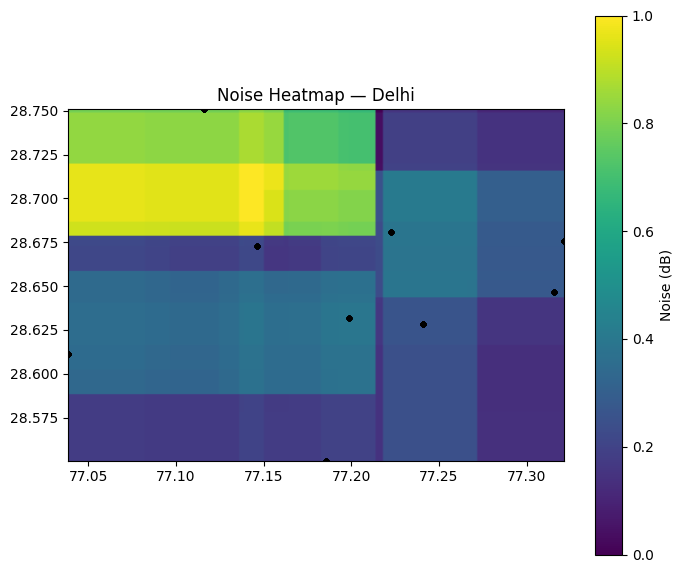

Mumbai  |  MAE: 1.048  |  R2: 0.896


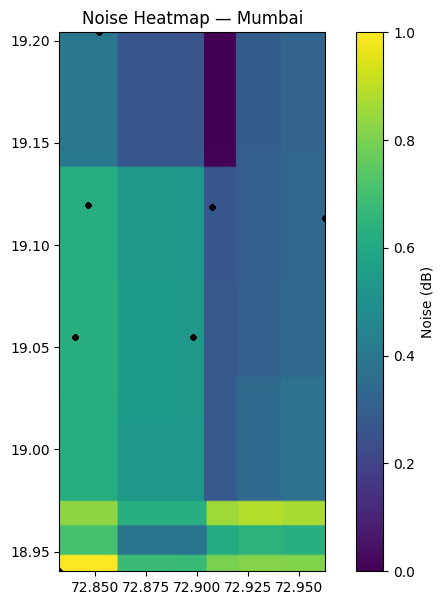

Bengaluru  |  MAE: 1.377  |  R2: 0.705


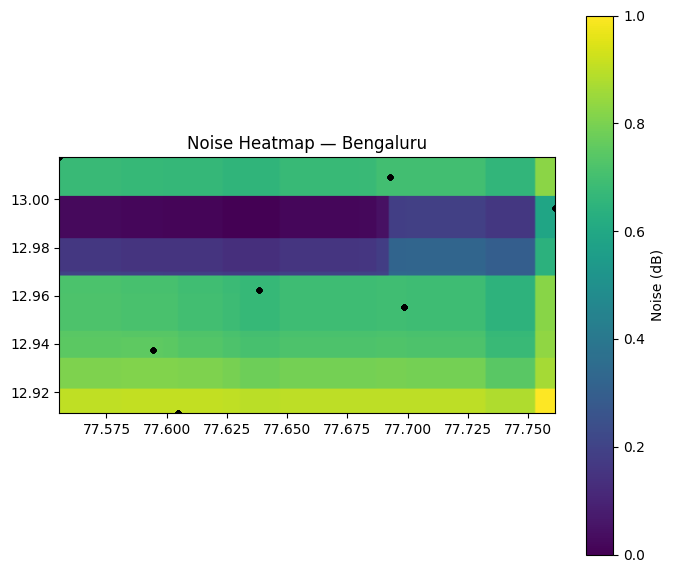

Chennai  |  MAE: 1.880  |  R2: 0.747


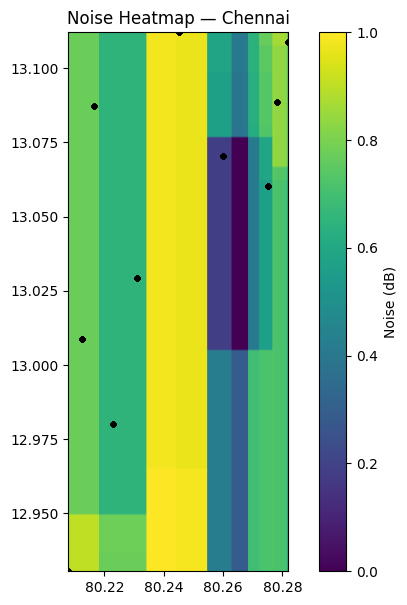

Hyderabad  |  MAE: 1.416  |  R2: 0.914


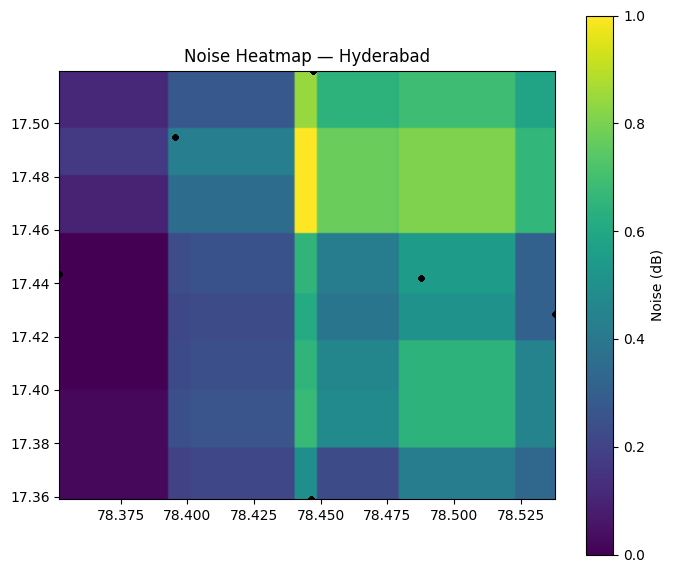

In [ ]:
for c in ["Delhi", "Mumbai", "Bengaluru", "Chennai", "Hyderabad"]:
    train_and_plot(c)
